<a href="https://colab.research.google.com/github/ehersch/MNIST_Demo/blob/main/mnist_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: The MNIST Dataset

This is dataset developed by the USPS in 1988 and the objective is simple: recognize handwritten digits. It includes 60k 28x28 training grayscale images and 10k images in the test set. Each image is associated with its appropriate digit as a label. Breakthroughs in CNNs tackled this dataset with high precision.

This is a simple problem for CNNs today but a good exercise to really understand everything going on in CNNs (and a way to clearly explain PyTorch and other important deep learning packages).

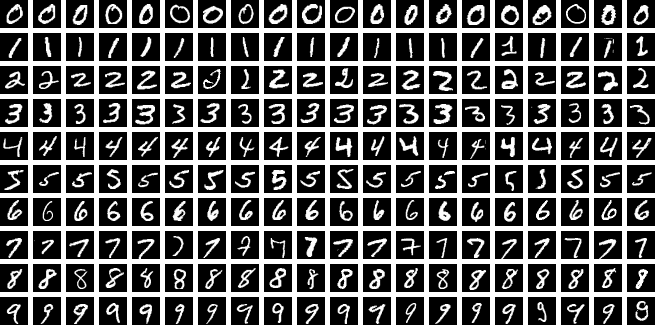

## Import all required deep learning packages

- `torch` (PyTorch) is critical for building our model
  - `torch.nn` is used for neural networks
  - `torch.nn.functional` allows us to use PyTorch activation functions, non-linearities, etc.
- `torch.optim` allows us to use the Adam optimizer
-  `torchvision` and `torchvision.transforms` contains image datasets (like MNIST) and transformations allowing us to easily transform an image to a tensor

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt # for graphing
import numpy as np

If we set runtime to GPU, the following `device` variable allows us to make sure inputs/data is appropriately converted to GPU.

Google AI Summary: *"Converting data to GPU means moving information (like numbers, images, or text) from the computer's main memory (CPU RAM) to the GPU's dedicated video memory (VRAM) so the GPU's powerful parallel processors can perform calculations on it much faster, speeding up tasks like video rendering, AI training, or scientific simulations by handling massive datasets simultaneously"*

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [23]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [9]:
trainset[0][0].shape # confirm 1 28x28 channel in an image

torch.Size([1, 28, 28])

Below we see what an image in the MNIST dataset looks like. We use `transforms.ToTensor()` to represent this as a tensor (something a CNN understands better).

In [12]:
# Old image w/o using a transform (just loads in raw image)
# trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
trainset[0][0]

## Developing the model

There are some choices we can make, but with a training set of 60k images, a model shouldn't be too big (otherwise, we run the risk of overfitting). All models are subclasses of PyTorch's `nn.Module`: https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html

There are two parts involved in creating a model in PyTorch. Firts define all the necessary components in `__init__` and then define a forward pass. Our model consists of:

- 2 convolution layers: https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
  - `self.conv1`: only 1 input channel (because a single 2D tensor) and `channels1` output channels, a stride of 1 and 3x3 filter
  - `self.conv2`: `channels1` input channels and `channels2` output channels, a stride of 1 and 3x3 filter
- `self.fc1` has `channels2 * 5 * 5` input channels because:
  - start with a 28x28 image, then a convolution with kernel size 3 makes this $28-3+1 = 26 \times 26$
  - after the first 2x2 pooling this becomes 13x13
  - apply another 3x3 convolution so this becomes 11x11
  - then another pooling layer drops this to $\lfloor{\frac{11}{2}}\rfloor = 5$
- `self.fc2` uses the same hidden dimension and its output is 10 dimensions (because we want the logits for digits 0 - 9)
- We use a 2d pool `self.pool` because pooling reduces the spatial resolution of feature maps, which lowers the number of parameters, improves efficiency, and helps the model learn more translation-invariant features, reducing overfitting on the MNIST dataset

**The forward pass**
- We first apply a convolution `conv1` to extract low-level local features (e.g., edges) from the raw image.

- A ReLU activation is applied immediately after to introduce non-linearity, allowing the model to learn complex patterns.

- We then apply max pooling to downsample the feature maps, keeping the most salient information while reducing spatial size and computation.

- This pattern (convolution to ReLU to pooling) is repeated with `conv2`, enabling the model to learn higher-level and more abstract features over larger receptive fields.

- After the convolutional layers, we `flatten` the feature maps into a 1D vector so they can be processed by fully connected layers.

- `fc1` combines all extracted features into a hidden representation, and a final ReLU adds non-linearity.

- `fc2` outputs 10 logits corresponding to the digit classes (0–9), which are used for classification.

In [14]:
class Model(nn.Module):
    def __init__(self, hidden, channels1, channels2):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, channels1, 3, 1)
        self.conv2 = nn.Conv2d(channels1, channels2, 3, 1)
        self.fc1 = nn.Linear(channels2 * 5 * 5, hidden)

        self.pool = nn.MaxPool2d(2,2)
        self.fc2 = nn.Linear(hidden, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

Define a model and optimizer for the first usage. This will have 128 hidden dimensions, 32 and 64 convolutional channels.

In [63]:
cnn_model = Model(128, 32, 64)

# move model to cude if available (want model AND data on GPU if can!)
if torch.cuda.is_available():
    cnn_model.cuda()

`cnn_model.parameters()` explicitly tells the optimizer which weights and biases belong to the model and should be trained

In [64]:
# cnn_model.parameters() returns an iterator over all learnable parameters
# (weights and biases) in the model, which the optimizer updates during training

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

## The train loop

- First move the model to training mode
  - This informs training-specific layers such as Dropout and BatchNorm (we're not using them here), which are designed to behave differently during training and evaluation

- In the loop:

  - Move data to GPU if available (use `device`)

  - Call `optimizer.zero_grad()` to clear gradients from the previous batch so they do not accumulate

  - Perform a forward pass by calling `model(X)` to obtain predicted logits

  - Compute the loss using cross-entropy, which measures how well the predictions match the true labels

  - Store the loss value for later analysis or plotting

  - Call `loss.backward()` to compute gradients of the loss with respect to all model parameters

  - Call `optimizer.step()` to update the model parameters using the computed gradients

In [65]:
def train(model, train_loader, optimizer, epochs):
    losses = []
    model.train() # good practice to keep even if not using BN or Dropout
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}\n-------------------------------")

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device) # move data over to same device as model (GPU when available)
            optimizer.zero_grad() # restart gradients
            y_pred = model(X)

            # multi-class classification problem where each image belongs to exactly one of 10 classes (digits 0–9).
            # The model outputs raw logits (one score per class), not probabilities.
            # CrossEntropyLoss is designed to work directly on logits, applying a LogSoftmax internally for numerical stability.
            loss = F.cross_entropy(y_pred, y)

            # loss.item() detaches the loss tensor item  from the computation graph
            # copies it to CPU if needed
            losses += [loss.item()] # use the item to get the float value (back on CPU)

            loss.backward()
            optimizer.step()
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_loader.dataset):>5d}]")

    return losses

Use the `train_loader` from torch to load our dataset with batch size 64 (for speed) and shuffle our dataset. We pass in a `train_loader` to our model.

In [66]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

### **Aside:** *cool exercise*
If you rerun the trianing loop now, loss will start SUPER low and the loss plot will just be noise. This is happening because just re-running the training loop does not re-initialize the model. So it's already good and loss won't go odwn the same way. To actually re-train the model, you have to re-initialize it as well. If this is not done, loss starts super low and stays low.
- Also make sure to re-run the optimizer. Otherwise, the loss will start high and stay high because the optimizer is optimizing parameters for the old model!

In [67]:
losses = train(cnn_model, train_loader=train_loader, optimizer=optimizer, epochs=10)


Epoch 1
-------------------------------
loss: 2.320398  [    0/60000]
loss: 0.265070  [ 6400/60000]
loss: 0.118887  [12800/60000]
loss: 0.166276  [19200/60000]
loss: 0.107825  [25600/60000]
loss: 0.233206  [32000/60000]
loss: 0.100675  [38400/60000]
loss: 0.041877  [44800/60000]
loss: 0.035801  [51200/60000]
loss: 0.073931  [57600/60000]

Epoch 2
-------------------------------
loss: 0.098655  [    0/60000]
loss: 0.011969  [ 6400/60000]
loss: 0.038577  [12800/60000]
loss: 0.010242  [19200/60000]
loss: 0.046325  [25600/60000]
loss: 0.019899  [32000/60000]
loss: 0.027816  [38400/60000]
loss: 0.026362  [44800/60000]
loss: 0.080481  [51200/60000]
loss: 0.013664  [57600/60000]

Epoch 3
-------------------------------
loss: 0.005229  [    0/60000]
loss: 0.056795  [ 6400/60000]
loss: 0.005658  [12800/60000]
loss: 0.011299  [19200/60000]
loss: 0.204303  [25600/60000]
loss: 0.011202  [32000/60000]
loss: 0.016419  [38400/60000]
loss: 0.038900  [44800/60000]
loss: 0.040828  [51200/60000]
loss: 0

In [68]:
def plot_loss(losses, epochs):
  """
    Plot batch-level losses on epoch scape
  """
  # Map batch index -> epoch fraction
  x = np.linspace(0, epochs, len(losses))
  plt.plot(x, losses)
  plt.xlabel("Epochs")
  plt.ylabel("Loss (CE)")
  plt.title("Loss vs Epochs")
  plt.xscale
  plt.show()

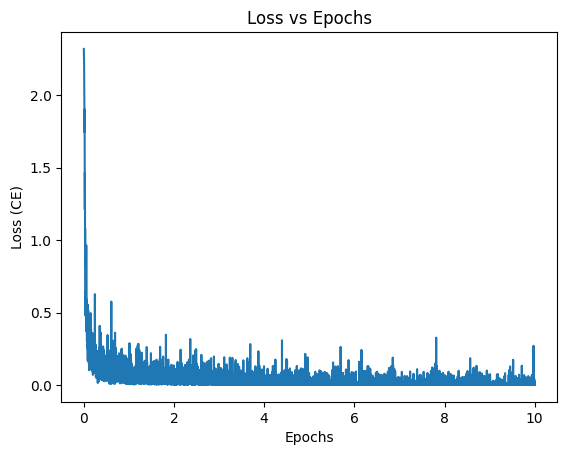

In [69]:
plot_loss(losses, 10)

## Model Evaluation

- `model.eval()` switches the model into evaluation mode, ensuring layers such as Dropout or BatchNorm behave deterministically

- `torch.no_grad()` disables gradient computation, reducing memory usage and improving inference speed

- For each test example, the model outputs a vector of logits (one score per class)

- The predicted class is obtained using argmax, which selects the class with the highest logit

- Predictions are compared to ground-truth labels to count correct classifications

- Final accuracy is computed as the ratio of correct predictions to total samples

In [76]:
# batch size DOES NOT need to be 1---our evaluation works for batching
test_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [61]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)                 # (batch_size, num_classes)
            preds = outputs.argmax(dim=1)      # predicted class indices

            correct += (preds == y).sum().item()
            total += y.size(0)

    print(f"Accuracy: {correct / total:.4f}")


In [70]:
evaluate(cnn_model, test_loader)

Accuracy: 0.9976


## Some ablation studies

See what happens if:
- We use more/fewer hidden dimensions
- We use more/fewer channels
- We change the convolution size
- Our model has more layers (try to get it to overfit)

In [71]:
# try 32 hidden dimensions instead
cnn_model = Model(32, 32, 64)

if torch.cuda.is_available():
    cnn_model.cuda()

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
losses = train(cnn_model, train_loader=train_loader, optimizer=optimizer, epochs=10)


Epoch 1
-------------------------------
loss: 2.322219  [    0/60000]
loss: 0.430424  [ 6400/60000]
loss: 0.228066  [12800/60000]
loss: 0.430686  [19200/60000]
loss: 0.063065  [25600/60000]
loss: 0.154942  [32000/60000]
loss: 0.195093  [38400/60000]
loss: 0.082087  [44800/60000]
loss: 0.169910  [51200/60000]
loss: 0.107582  [57600/60000]

Epoch 2
-------------------------------
loss: 0.069733  [    0/60000]
loss: 0.018994  [ 6400/60000]
loss: 0.128188  [12800/60000]
loss: 0.084593  [19200/60000]
loss: 0.024205  [25600/60000]
loss: 0.039205  [32000/60000]
loss: 0.013439  [38400/60000]
loss: 0.041766  [44800/60000]
loss: 0.019177  [51200/60000]
loss: 0.023900  [57600/60000]

Epoch 3
-------------------------------
loss: 0.012739  [    0/60000]
loss: 0.014450  [ 6400/60000]
loss: 0.001651  [12800/60000]
loss: 0.006290  [19200/60000]
loss: 0.015206  [25600/60000]
loss: 0.014582  [32000/60000]
loss: 0.011444  [38400/60000]
loss: 0.020098  [44800/60000]
loss: 0.013738  [51200/60000]
loss: 0

In [72]:
evaluate(cnn_model, test_loader)

Accuracy: 0.9981


**Conclusion:** with fewer hidden dimensions, loss is lower during training and accuracy is higher.

In [79]:
# use more hidden dimensions
cnn_model = Model(256, 32, 64)

if torch.cuda.is_available():
    cnn_model.cuda()

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
losses = train(cnn_model, train_loader=train_loader, optimizer=optimizer, epochs=10)


Epoch 1
-------------------------------
loss: 2.305208  [    0/60000]
loss: 0.262862  [ 6400/60000]
loss: 0.074791  [12800/60000]
loss: 0.104091  [19200/60000]
loss: 0.089911  [25600/60000]
loss: 0.093554  [32000/60000]
loss: 0.010572  [38400/60000]
loss: 0.014063  [44800/60000]
loss: 0.040387  [51200/60000]
loss: 0.097516  [57600/60000]

Epoch 2
-------------------------------
loss: 0.036361  [    0/60000]
loss: 0.007947  [ 6400/60000]
loss: 0.062732  [12800/60000]
loss: 0.028371  [19200/60000]
loss: 0.061187  [25600/60000]
loss: 0.080606  [32000/60000]
loss: 0.010722  [38400/60000]
loss: 0.010517  [44800/60000]
loss: 0.057066  [51200/60000]
loss: 0.019288  [57600/60000]

Epoch 3
-------------------------------
loss: 0.022618  [    0/60000]
loss: 0.066869  [ 6400/60000]
loss: 0.032999  [12800/60000]
loss: 0.006564  [19200/60000]
loss: 0.007784  [25600/60000]
loss: 0.002552  [32000/60000]
loss: 0.002430  [38400/60000]
loss: 0.027652  [44800/60000]
loss: 0.002804  [51200/60000]
loss: 0

In [80]:
evaluate(cnn_model, test_loader)

Accuracy: 0.9984


**Conclusion:** unsurprisingly, loss seems to get a bit lower. Accuracy is *highest* here.

In [74]:
# use 2x the number of channels
cnn_model = Model(128, 64, 128)

if torch.cuda.is_available():
    cnn_model.cuda()

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
losses = train(cnn_model, train_loader=train_loader, optimizer=optimizer, epochs=10)


Epoch 1
-------------------------------
loss: 2.297661  [    0/60000]
loss: 0.257087  [ 6400/60000]
loss: 0.066379  [12800/60000]
loss: 0.063228  [19200/60000]
loss: 0.057288  [25600/60000]
loss: 0.083778  [32000/60000]
loss: 0.071338  [38400/60000]
loss: 0.006247  [44800/60000]
loss: 0.032437  [51200/60000]
loss: 0.046750  [57600/60000]

Epoch 2
-------------------------------
loss: 0.015926  [    0/60000]
loss: 0.015748  [ 6400/60000]
loss: 0.006565  [12800/60000]
loss: 0.101105  [19200/60000]
loss: 0.051849  [25600/60000]
loss: 0.005223  [32000/60000]
loss: 0.007580  [38400/60000]
loss: 0.005071  [44800/60000]
loss: 0.005383  [51200/60000]
loss: 0.084507  [57600/60000]

Epoch 3
-------------------------------
loss: 0.001737  [    0/60000]
loss: 0.006299  [ 6400/60000]
loss: 0.008767  [12800/60000]
loss: 0.019565  [19200/60000]
loss: 0.002432  [25600/60000]
loss: 0.002386  [32000/60000]
loss: 0.011788  [38400/60000]
loss: 0.084117  [44800/60000]
loss: 0.051468  [51200/60000]
loss: 0

In [75]:
evaluate(cnn_model, test_loader)

Accuracy: 0.9980


**Conclusion:** unsurprisingly, the loss also looks much lower (more parameters, so more prone to overfitting). The accuracy also gets higher.

In [81]:
# use half the number of channels
cnn_model = Model(128, 16, 32)

if torch.cuda.is_available():
    cnn_model.cuda()

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
losses = train(cnn_model, train_loader=train_loader, optimizer=optimizer, epochs=10)


Epoch 1
-------------------------------
loss: 2.308665  [    0/60000]
loss: 0.240276  [ 6400/60000]
loss: 0.171976  [12800/60000]
loss: 0.402778  [19200/60000]
loss: 0.084654  [25600/60000]
loss: 0.027198  [32000/60000]
loss: 0.062865  [38400/60000]
loss: 0.144507  [44800/60000]
loss: 0.066755  [51200/60000]
loss: 0.152946  [57600/60000]

Epoch 2
-------------------------------
loss: 0.038324  [    0/60000]
loss: 0.052908  [ 6400/60000]
loss: 0.012385  [12800/60000]
loss: 0.102596  [19200/60000]
loss: 0.222098  [25600/60000]
loss: 0.057079  [32000/60000]
loss: 0.030605  [38400/60000]
loss: 0.026793  [44800/60000]
loss: 0.184044  [51200/60000]
loss: 0.059390  [57600/60000]

Epoch 3
-------------------------------
loss: 0.003315  [    0/60000]
loss: 0.074713  [ 6400/60000]
loss: 0.004090  [12800/60000]
loss: 0.041603  [19200/60000]
loss: 0.008647  [25600/60000]
loss: 0.013515  [32000/60000]
loss: 0.012422  [38400/60000]
loss: 0.044981  [44800/60000]
loss: 0.054687  [51200/60000]
loss: 0

In [82]:
evaluate(cnn_model, test_loader)

Accuracy: 0.9976


**Conclusion:** fewer channels doesn't really change much. This could be better to use than our original model. It's fewer parameters so more efficient.

In [83]:
# use half the number of hidden dimensions
cnn_model = Model(64, 32, 64)

if torch.cuda.is_available():
    cnn_model.cuda()

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
losses = train(cnn_model, train_loader=train_loader, optimizer=optimizer, epochs=10)


Epoch 1
-------------------------------
loss: 2.306817  [    0/60000]
loss: 0.476266  [ 6400/60000]
loss: 0.188461  [12800/60000]
loss: 0.053484  [19200/60000]
loss: 0.051943  [25600/60000]
loss: 0.067593  [32000/60000]
loss: 0.073013  [38400/60000]
loss: 0.090775  [44800/60000]
loss: 0.150809  [51200/60000]
loss: 0.023338  [57600/60000]

Epoch 2
-------------------------------
loss: 0.028970  [    0/60000]
loss: 0.047997  [ 6400/60000]
loss: 0.088327  [12800/60000]
loss: 0.086509  [19200/60000]
loss: 0.018876  [25600/60000]
loss: 0.013292  [32000/60000]
loss: 0.091531  [38400/60000]
loss: 0.017856  [44800/60000]
loss: 0.022370  [51200/60000]
loss: 0.027061  [57600/60000]

Epoch 3
-------------------------------
loss: 0.067677  [    0/60000]
loss: 0.022636  [ 6400/60000]
loss: 0.001303  [12800/60000]
loss: 0.008085  [19200/60000]
loss: 0.031793  [25600/60000]
loss: 0.068846  [32000/60000]
loss: 0.108934  [38400/60000]
loss: 0.011287  [44800/60000]
loss: 0.010327  [51200/60000]
loss: 0

In [84]:
evaluate(cnn_model, test_loader)

Accuracy: 0.9973


**Conclusion:** performance here gets worse. It seems sufficient hidden dimensions in the classification network is actually important for performance.

## Overall project conclusion

This project forced me to really understand every step of training a neural network. I gained more understanding of specifics in PyTorch. Instead of just copy and pasting code or having AI write it (this is fine to do in practice as long as you understand what's going on), I read documentation to understand every step. Now, when I use AI tools or just copy and paste, I can be pretty confident I **actually** know what's going on.

*This is part of my initiative to stop just being a user of ML/DL/AI packages and either implement them on my own (currently working on this), or make sure I understand every step well.*

## Next steps: use nn.sequential since I am not using ResNet connections or any more complicated structures, I can just use nn.sequential to simplify the design!

This will improve the **modularity** of the code.

### Create `conv_block`
- A single convolution block does `Conv2d`, `ReLU`, and `MaxPool2d`. Encode this with `nn.Sequential`
  - Wrap it in a function to work for various dimensions `in_channels` and `out_channels`

- `self.features` (which extracts these image features) will then use the splat operator (*) to unpack a list of the conv_blocks (a list because a list of channel dimensions is passed into our model)

- Then infer the first feature of the linear layer dynamically (see below)

- Finally, define a single `classifier_block` using a similar procedure as above (assuming the hidden features are also passed in as a list)
  - Each hidden layer does a linear layer and ReLU

### Infer first feature size dynamically

- We create a dummy input tensor with the same shape as a real MNIST image (1x28x28), including a batch dimension

- This dummy tensor is passed through the convolutional feature extractor `self.features` exactly as a real input would be

- The output of self.features is a multi-dimensional tensor of shape (batch_size, channels, height, width)

- Calling `.numel()` counts the total number of scalar values in this tensor (excluding the batch dimension), which is exactly the number of inputs required by the first fully connected layer

- Wrapping this logic in `torch.no_grad()` disables gradient tracking since this computation is only used to determine tensor shapes, not for training

In [94]:
class Model(nn.Module):
    def __init__(self, hidden_list, channels_list):
        super().__init__()

        assert channels_list[0] == 1, "channels_list must start with input channels = 1 for MNIST"

        def conv_block(in_channels, out_channels):
          """
            Creates a convolutional block of arbitrary channels for modularity.
          """
          return nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1),
              nn.ReLU(),
              nn.MaxPool2d(2, 2),
          )

        # leverage the splat operator * to unpack iterators
        self.features = nn.Sequential(
            *[
                conv_block(channels_list[i], channels_list[i + 1])
                for i in range(len(channels_list) - 1)
            ]
        )

        # infer feature size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            n_features = self.features(dummy).numel()

        def classifier_block(in_features, out_features):
          """
            Creates a classifier block of arbitrary hidden dimensions.
          """
          return nn.Sequential(
              nn.Linear(in_features, out_features),
              nn.ReLU(),
        )

        hidden_list = [n_features] + hidden_list # the first layer has n_features

        self.classifier = nn.Sequential(
            *[
                classifier_block(hidden_list[i], hidden_list[i + 1])
                for i in range(len(hidden_list) - 1)
            ],
            nn.Linear(hidden_list[-1], 10), # put the final prediction head on
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [90]:
sequential_model = Model([32, 64, 128, 64, 32], [1, 32, 64])

if torch.cuda.is_available():
    sequential_model.cuda()

optimizer = optim.Adam(sequential_model.parameters(), lr=0.001)
losses = train(sequential_model, train_loader=train_loader, optimizer=optimizer, epochs=10)


Epoch 1
-------------------------------
loss: 2.281033  [    0/60000]
loss: 1.174370  [ 6400/60000]
loss: 0.674400  [12800/60000]
loss: 0.375452  [19200/60000]
loss: 0.104812  [25600/60000]
loss: 0.190450  [32000/60000]
loss: 0.300062  [38400/60000]
loss: 0.362765  [44800/60000]
loss: 0.259717  [51200/60000]
loss: 0.090351  [57600/60000]

Epoch 2
-------------------------------
loss: 0.106728  [    0/60000]
loss: 0.041591  [ 6400/60000]
loss: 0.061140  [12800/60000]
loss: 0.193462  [19200/60000]
loss: 0.061534  [25600/60000]
loss: 0.083986  [32000/60000]
loss: 0.111603  [38400/60000]
loss: 0.051240  [44800/60000]
loss: 0.011733  [51200/60000]
loss: 0.054018  [57600/60000]

Epoch 3
-------------------------------
loss: 0.046289  [    0/60000]
loss: 0.051706  [ 6400/60000]
loss: 0.101909  [12800/60000]
loss: 0.015578  [19200/60000]
loss: 0.022208  [25600/60000]
loss: 0.071291  [32000/60000]
loss: 0.055097  [38400/60000]
loss: 0.026724  [44800/60000]
loss: 0.063107  [51200/60000]
loss: 0

In [91]:
evaluate(sequential_model, test_loader)

Accuracy: 0.9964


**Conclusion:** adding a lot of layers (many convolutions and linear layers) hurts erformance to 99.6%

Below is a sanity check to make sure this midular design accomplishes the same thing


In [95]:
test_sequential_model = Model([128], [1, 32, 64])

if torch.cuda.is_available():
    test_sequential_model.cuda()

optimizer = optim.Adam(test_sequential_model.parameters(), lr=0.001)
losses = train(test_sequential_model, train_loader=train_loader, optimizer=optimizer, epochs=10)


Epoch 1
-------------------------------
loss: 2.306855  [    0/60000]
loss: 0.274187  [ 6400/60000]
loss: 0.128035  [12800/60000]
loss: 0.115577  [19200/60000]
loss: 0.088418  [25600/60000]
loss: 0.121743  [32000/60000]
loss: 0.135479  [38400/60000]
loss: 0.038645  [44800/60000]
loss: 0.100504  [51200/60000]
loss: 0.030053  [57600/60000]

Epoch 2
-------------------------------
loss: 0.159796  [    0/60000]
loss: 0.052132  [ 6400/60000]
loss: 0.051489  [12800/60000]
loss: 0.019806  [19200/60000]
loss: 0.039403  [25600/60000]
loss: 0.042790  [32000/60000]
loss: 0.002312  [38400/60000]
loss: 0.032203  [44800/60000]
loss: 0.053122  [51200/60000]
loss: 0.020263  [57600/60000]

Epoch 3
-------------------------------
loss: 0.075879  [    0/60000]
loss: 0.007477  [ 6400/60000]
loss: 0.007418  [12800/60000]
loss: 0.039501  [19200/60000]
loss: 0.035889  [25600/60000]
loss: 0.016881  [32000/60000]
loss: 0.006446  [38400/60000]
loss: 0.087465  [44800/60000]
loss: 0.038735  [51200/60000]
loss: 0

In [96]:
evaluate(test_sequential_model, test_loader)

Accuracy: 0.9980
